# Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil

import numpy as np
import pandas as pd
import math
import itertools

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# SKLearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import pickle

# Data Cleaning

In [2]:
#THIS IS THE IMPUT BY THE USER
new_df_acc=pd.read_csv("acc_test_5.csv")


#Cleaning functions
def half_int(x):
    val=0.5 * math.ceil(2.0 * x)
    return val


def cleaning_tests(df_acc):
    # Rename df_acc column, 'train' -> 'mode'
    df_acc.columns = ['TI', 'TS', 'x', 'y', 'z', 'mode']

    # Drop TS column and replace transportation mode into integer
    df_acc = df_acc.drop(columns=["TS"]).replace({'mode': {'Train': 1, 'Walking': 0}})

    # Convert TI value to integer
    df_acc['TI'] = df_acc['TI'].apply(lambda x: half_int(x))


    # Group by and get mean by TI as key
    ndf_acc = df_acc.groupby(['TI'], as_index=False)[['x', 'y', 'z', 'mode']].mean()


    # Clean filtered data
    ndf_acc.columns = ['TI', 'acc_x', 'acc_y', 'acc_z', 'mode']
    
    return ndf_acc

#TEST FILE IN CSV FORMAT
new_df=cleaning_tests(new_df_acc)

df=new_df

#Mag + Overlapping for test
df['acc_magnitude']=(df['acc_x']**2+df['acc_y']**2+df['acc_z']**2)**(1/2.0)

#Overlapping
n=10
o=5
X_new=[df['acc_magnitude'].values[x:x+n] for x in range(0,len(df['acc_magnitude'])-n+1, o) if (df.iloc[x]['mode'] == df.iloc[x+n-1]['mode'])]
X_new=np.asarray(X_new)

Y_new=[df['mode'].values[x] for x in range(0,len(df['mode'])-n+1, o) if df.iloc[x]['mode'] == df.iloc[x+n-1]['mode']]
Y_new=np.asarray(Y_new)

times=[df['TI'].values[x] for x in range(0,len(df['TI'])-n+1, o) if df.iloc[x]['mode'] == df.iloc[x+n-1]['mode']]

times_ref=new_df_acc
times_ref['TI']=new_df_acc['TI'].apply(lambda x: half_int(x))
times_ref=times_ref.loc[times_ref['TI'].isin(times)]
times_ref=times_ref.drop_duplicates(subset='TI', keep="last")['TS']

# Loading Trained Model

In [3]:
filename = 'train_walk_model.sav'
knn = pickle.load(open(filename, 'rb'))

# Results

In [4]:
#Predicting Classification with model trained
pred_new = knn.predict(X_new)

#Classification Probabilities
probs=knn.predict_proba(X_new)

#Overall Accuracy of the model
sklearn.metrics.accuracy_score(Y_new, pred_new)

0.7886776145203112

# Confusion Matrix (Visualization)

Normalized confusion matrix
[[0.36 0.64]
 [0.01 0.99]]


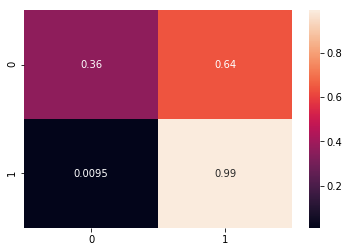

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
  
    sns.heatmap(cm, annot=True)

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_new, pred_new)
np.set_printoptions(precision=2)



plot_confusion_matrix(cnf_matrix, normalize=True, classes=["Walking", "Train", "Bus"],
                      title='Normalized confusion matrix')

plt.show()

# Export Results as CSV Files

In [6]:
#Saving CSV Classification
results=np.column_stack([np.transpose(np.column_stack(times_ref)) ,np.transpose(np.column_stack(pred_new))])
df_results=pd.DataFrame(results)
df_results.to_csv("results_train_walk.csv")

#Saving Probabilities
df_probs=pd.DataFrame(probs)
df_probs.to_csv("probabilities_train_walk.csv")
                                      